# 5. Topic Modeling

**Table of Contents:**
- Topic Modeling per community:
  - WordCloud
  - BERTopic
- Topic modeling per time window

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from wordcloud import WordCloud
import praw
import pandas as pd
import json
from datetime import datetime
from nltk.corpus import stopwords
import nltk
from PIL import Image
from bertopic import BERTopic


# load
df_ending = pd.read_csv('../data/aot_ending.csv')
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])
df_comments = pd.read_csv('../data/comments_graph_ending_final.csv')
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'])
df_communities = pd.read_csv('../data/communities.csv')
G = pickle.load(open('../data/comments_graph.pickle', 'rb'))
df_communities = pd.read_csv('../data/communities.csv')

## Topic Modeling per community

### World Cloud

In [4]:
node_to_comm = dict(zip(df_communities["node"], df_communities["infomap_community"]))
def get_community(row):
    parent_comm = node_to_comm.get(row["parent"])
    child_comm = node_to_comm.get(row["child"])
    if parent_comm is not None and child_comm is not None:
        if parent_comm == child_comm:
            return parent_comm
        else:
            return None # skeep inter-community edges
    elif parent_comm is not None:
        return parent_comm
    elif child_comm is not None:
        return child_comm
    else:
        return None

df_comments["community"] = df_comments.apply(get_community, axis=1)
df_comments_comm = df_comments[df_comments["community"].notna()].copy()
df_comments_comm["community"] = df_comments_comm["community"].astype(int)
community_texts = df_comments_comm.groupby("community")["text_comment"].apply(list).to_dict()
print(community_texts[0][:3])

["I know I'm late, but I was going to say this too....also, I think it's how they take in the fluid causes deformity.  Either by ingesting it, injecting in various parts of the body, etc...", '“Well, well, well, if it isn’t the consequences of my own actions.”', 'Yup , he was putting in that work against Eren but like Pieck told him he’s so agitated and impatient. Why do you dislike Porco ? Personally I don’t really dislike any of the warriors anymore but I have a better ‘connection’ with the people of Paradis Island so I’ll root for them.']


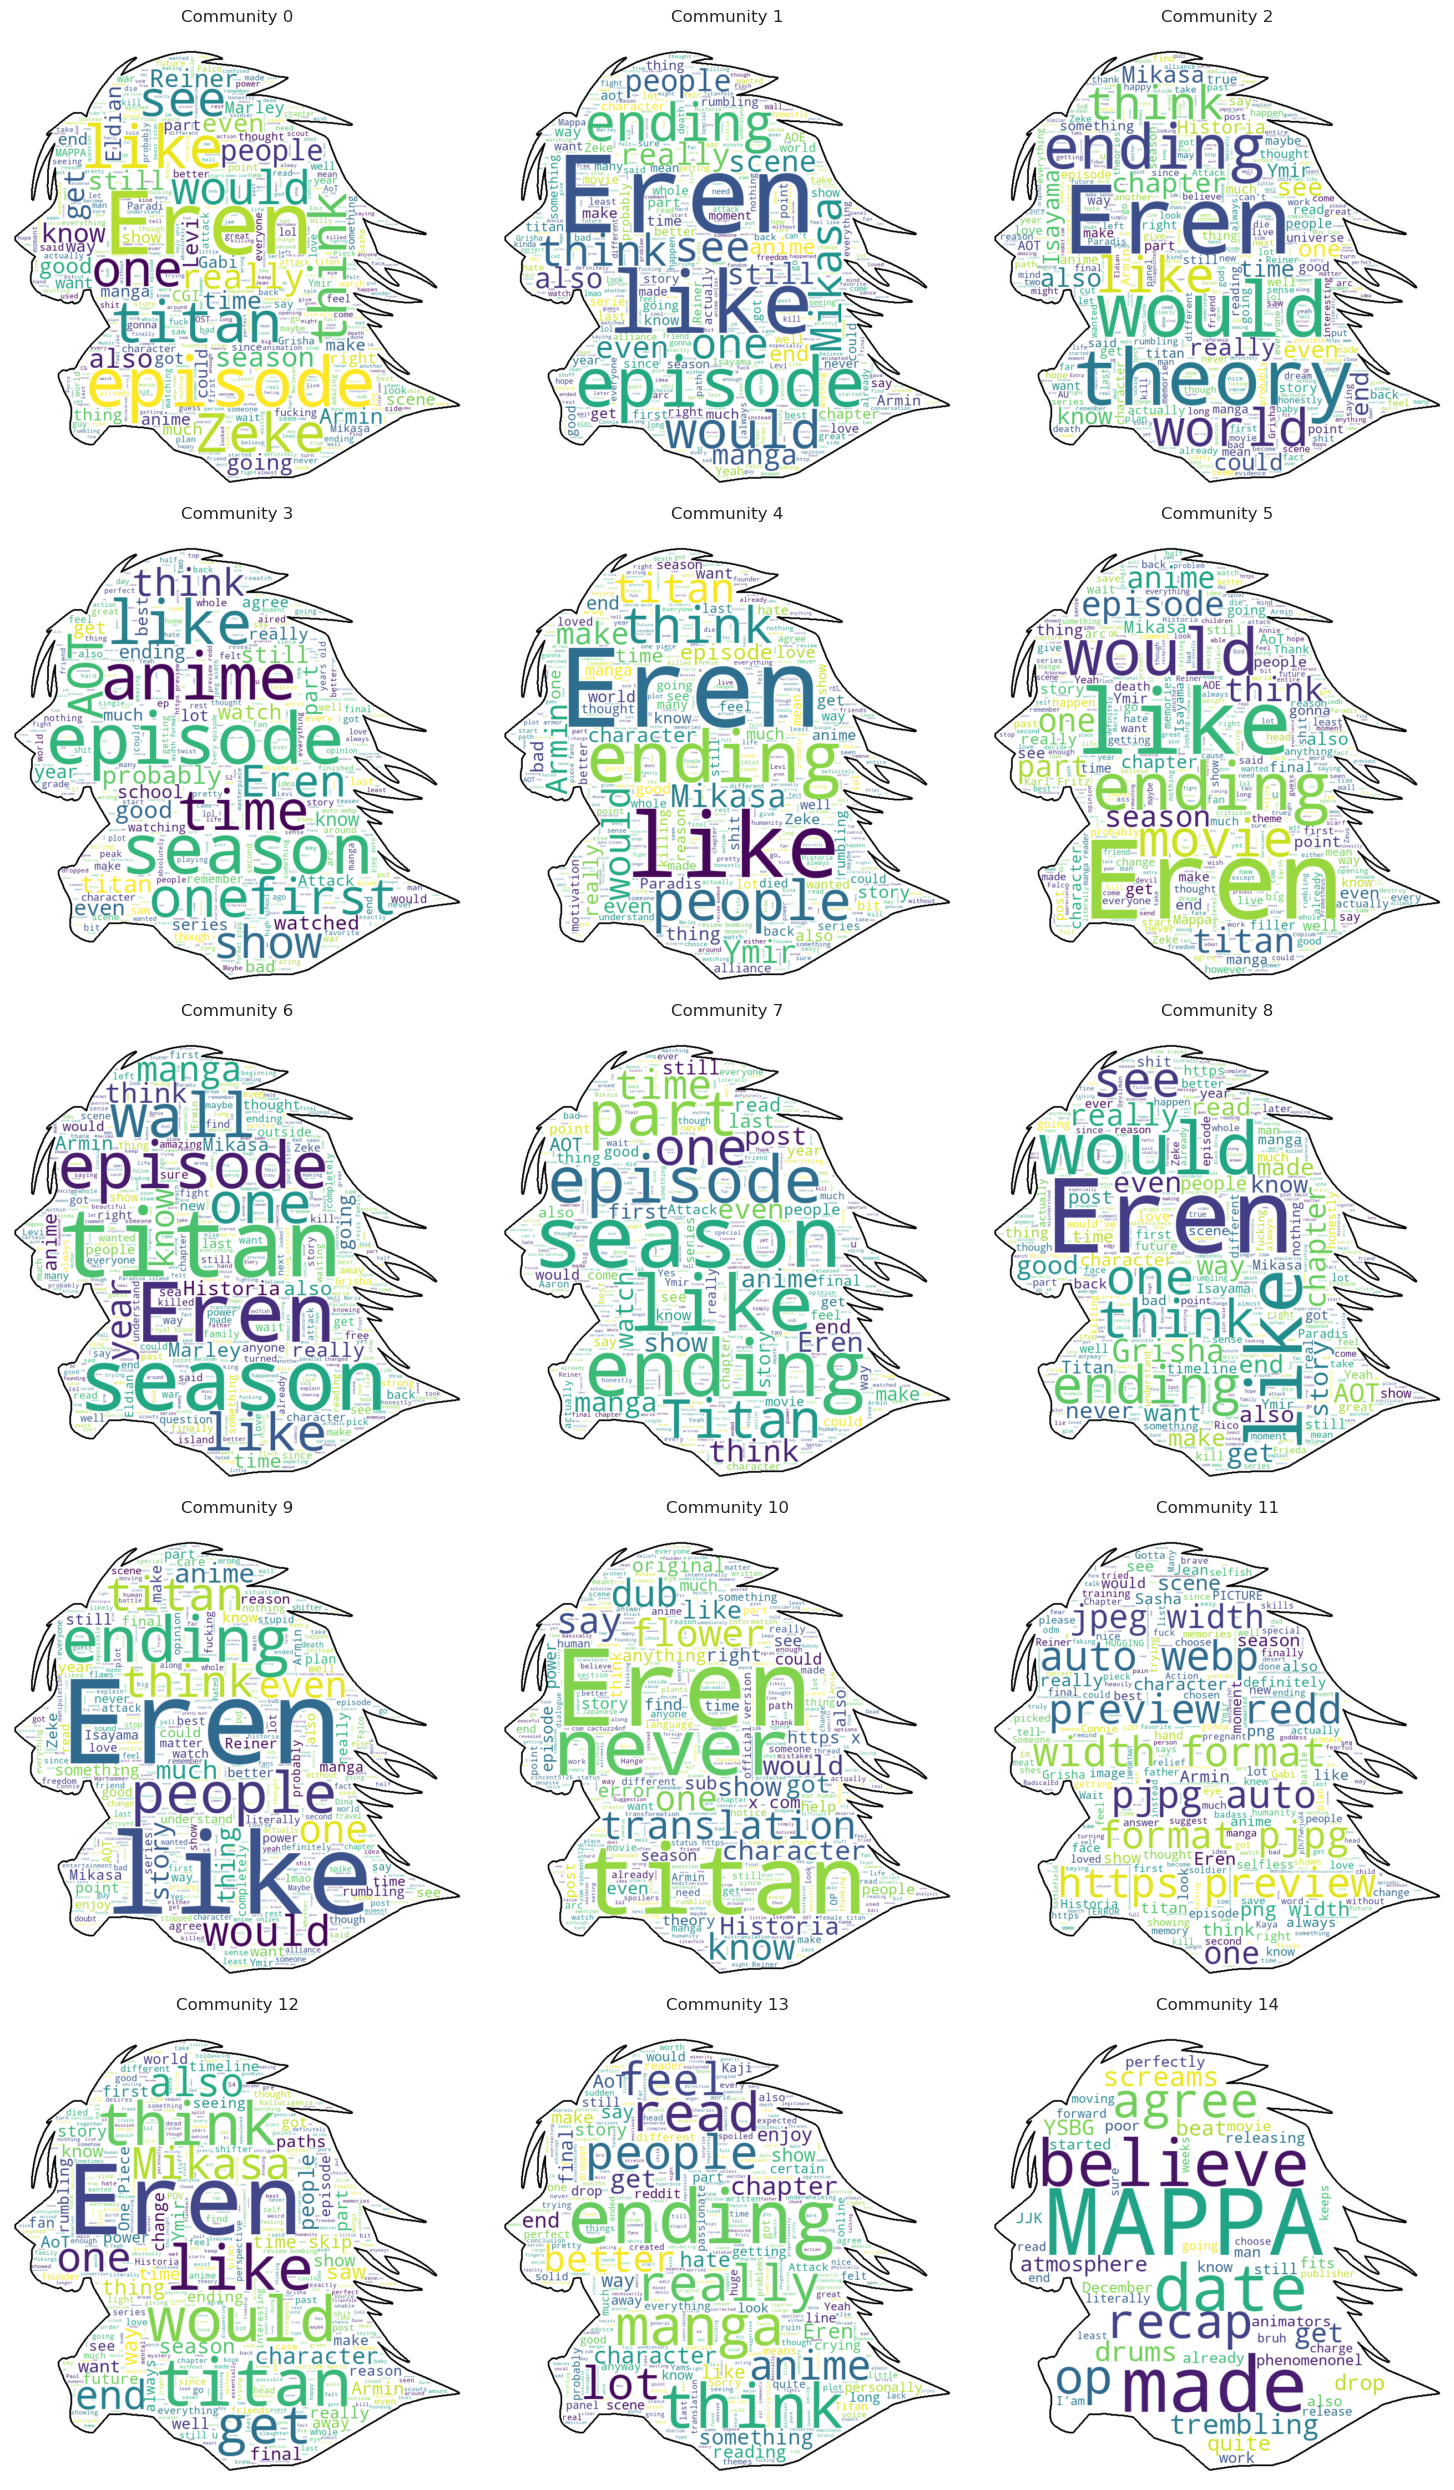

In [ ]:
# mask
img = Image.open('../images/mask_erenTitanForm.jpeg')
eren_mask = np.array(img).mean(axis=2).astype(np.uint8)
threshold = 128  # You can adjust this value
eren_mask = np.where(eren_mask > threshold, 255, 0).astype(np.uint8)

# This time we can't remove the domain specific stopwords like the names of the characters.
# we are delving into the communities for trying to differentiate them.
nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

# Create subplots with 3 columns per row
communities = list(community_texts.keys())
num_communities = len(communities)
rows = (num_communities + 2) // 3  # Calculate number of rows needed

fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes

for i, comm in enumerate(communities):
    texts = community_texts[comm]
    combined_text = " ".join(texts)
    wc = WordCloud(
        width=800, height=400, background_color="white", colormap='viridis',
        stopwords=STOPWORDS, max_words=500,
        mask=eren_mask, contour_width=2, contour_color='black'
    ).generate(combined_text)
    
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Community {comm}")

# Hide any unused subplots
for i in range(num_communities, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Eren is in the minds of all the communities (literally)

## BERTopic

[BERTopic](https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html)


1. **BERT Embeddings**:  
BERTopic uses BERT, a language model, to create contextualized embeddings for each document in the corpus. These embeddings capture the semantic meaning of the text. 
1. **UMAP Dimensionality Reduction**:  
The high-dimensional BERT embeddings are reduced using UMAP, a dimensionality reduction technique. This simplifies the clustering process and makes the topics more interpretable. 
1. **HDBSCAN Clustering**:  
HDBSCAN, a density-based clustering algorithm, is used to group similar documents into topics. 
1. **c-TF-IDF for Topic Representation**:  
Class-based TF-IDF (c-TF-IDF) is used to generate descriptive phrases for each topic. It calculates the term frequency and inverse document frequency within each cluster, for highlighting the most important words for that topic. 

In [7]:
topic_models = {}
for comm, texts in community_texts.items():
    if len(texts) > 10:  # avoid too small sets
        topic_model = BERTopic(language="english")
        topics, probs = topic_model.fit_transform(texts)
        topic_models[comm] = topic_model


We can plot in the embedding spaces (actually the dimensionality reduction of them) the topics that are covered

In [8]:
comm = 0
topic_models[comm].visualize_topics()


`Topic = -1` refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [11]:
topic_models[0].get_topic_info()


Topic  Count                                 Name  \
0       -1   3029                   -1_the_to_and_eren   
1        0    654      0_season_final_episode_episodes   
2        1    290        1_marley_paradis_eldians_they   
3        2    217               2_mappa_mappas_cgi_wit   
4        3    209               3_cgi_cg_looked_titans   
..     ...    ...                                  ...   
142    141     10            141_annie_crystal_eat_gem   
143    142     10      142_levi_saved_alone_10302010th   
144    143     10      143_armored_handsome_armor_face   
145    144     10  144_soulmadness_madness_soul_motion   
146    145     10             145_ost_felt_moment_have   

                                        Representation  \
0    [the, to, and, eren, of, that, is, was, it, this]   
1    [season, final, episode, episodes, part, this,...   
2    [marley, paradis, eldians, they, their, them, ...   
3    [mappa, mappas, cgi, wit, studio, animation, j...   
4    [cgi, cg, looked, titans, 2d, beast, good, gre...   
..                                                 ...   
142  [annie, crystal, eat, gem, hammer, break, egg,...   
143  [levi, saved, alone, 10302010th, husk, kingroy...   
144  [armored, handsome, armor, face, differentthey...   
145  [soulmadness, madness, soul, motion, betterthi...   
146  [ost, felt, moment, have, manga, dialogue, bre...   

                                   Representative_Docs  
0    [This episode was honestly hard to watch at ti...  
1    [Final season final part, Final season part 4 ...  
2    [I have mixed feelings on this episode it’s go...  
3    [I'll be honest, I might have like terrible ey...  
4    [The highlights of the episode:\n-The OP with ...  
..                                                 ...  
142  [I got one thing to say. If eren was about to ...  
143  [Seemed like Eren orchestrated most of this on...  
144  [Really liked the anime original scenes they a...  
145  [Yeah I was dissapointed... In myself. I overh...  
146  [Kind of disappointing I can't lie. It was obv...  

[147 rows x 5 columns]

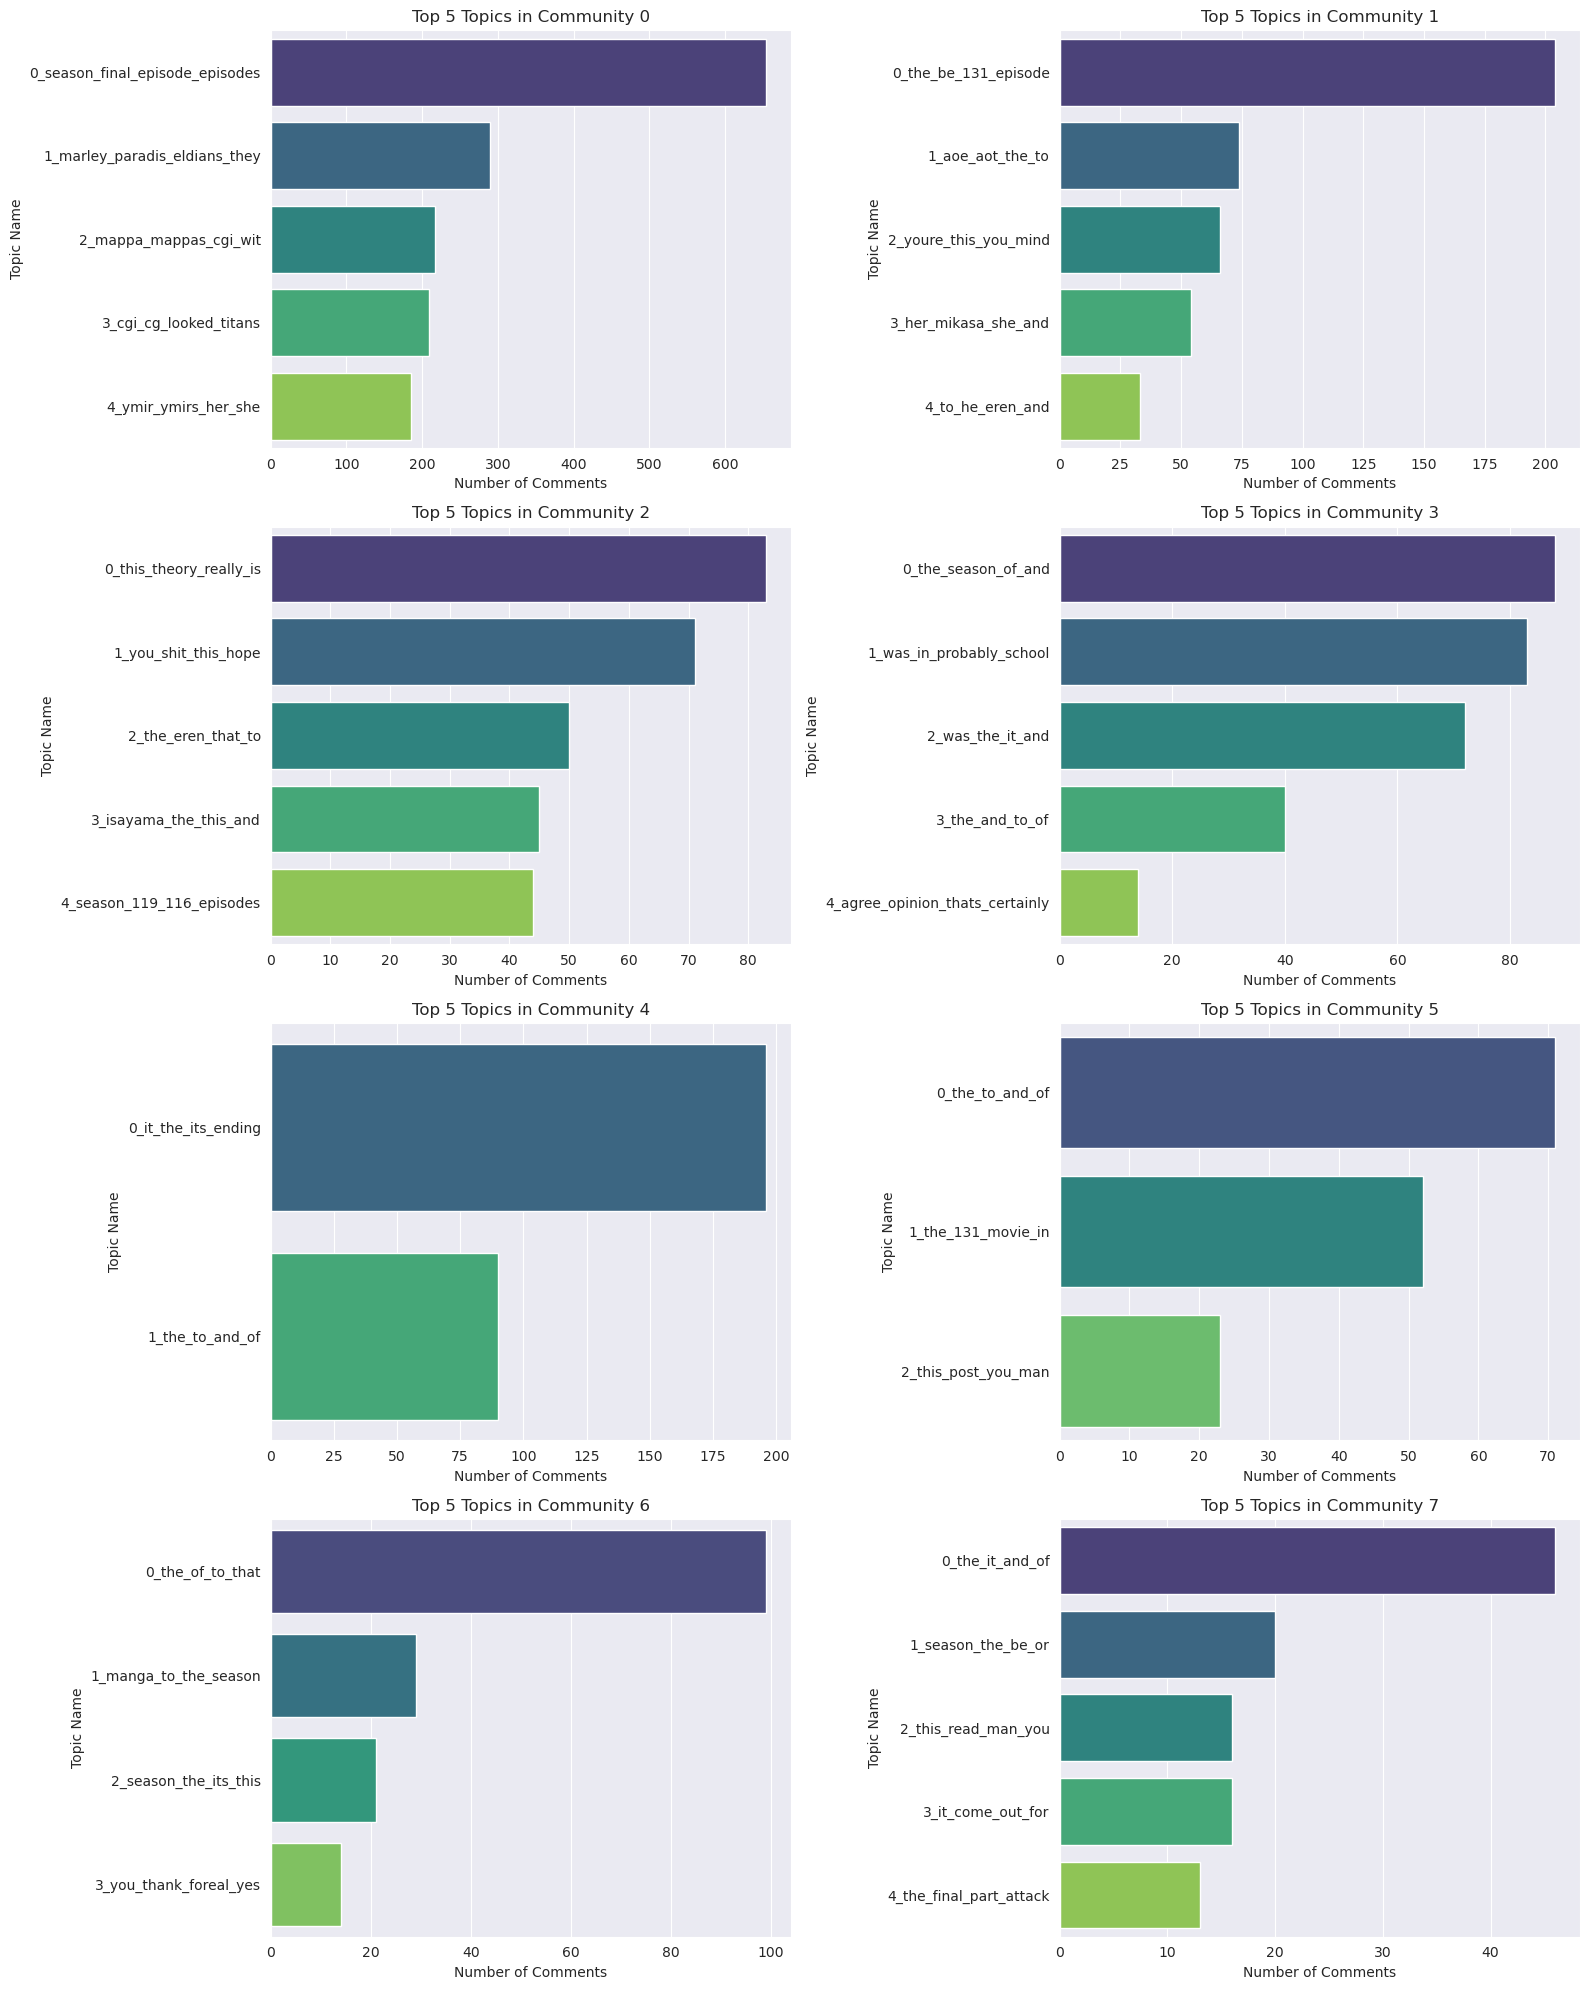

In [14]:
def plot_topic_counts(topic_df, community_id, top_n=5):
    # Skip outlier topic (-1) and get top topics
    df_plot = topic_df[topic_df['Topic'] != -1].sort_values(by='Count', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='Count', y='Name', palette='viridis')
    plt.title(f"Top {top_n} Topics in Community {community_id}")
    plt.xlabel("Number of Comments")
    plt.ylabel("Topic Name")
    plt.tight_layout()
    plt.show()

# Get top 8 communities by size
top_communities = sorted(topic_models.keys())[:8]

# Create subplots with 2 columns per row
rows = (len(top_communities) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(16, 5*rows))
axes = axes.flatten()

for i, comm in enumerate(top_communities):
    topic_df = topic_models[comm].get_topic_info()
    df_plot = topic_df[topic_df['Topic'] != -1].sort_values(by='Count', ascending=False).head(5)
    
    if not df_plot.empty:
        sns.barplot(data=df_plot, x='Count', y='Name', palette='viridis', ax=axes[i])
        axes[i].set_title(f"Top 5 Topics in Community {comm}")
        axes[i].set_xlabel("Number of Comments")
        axes[i].set_ylabel("Topic Name")
    else:
        axes[i].text(0.5, 0.5, f"No topics found\nfor Community {comm}", 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f"Community {comm}")

# Hide any unused subplots
for i in range(len(top_communities), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


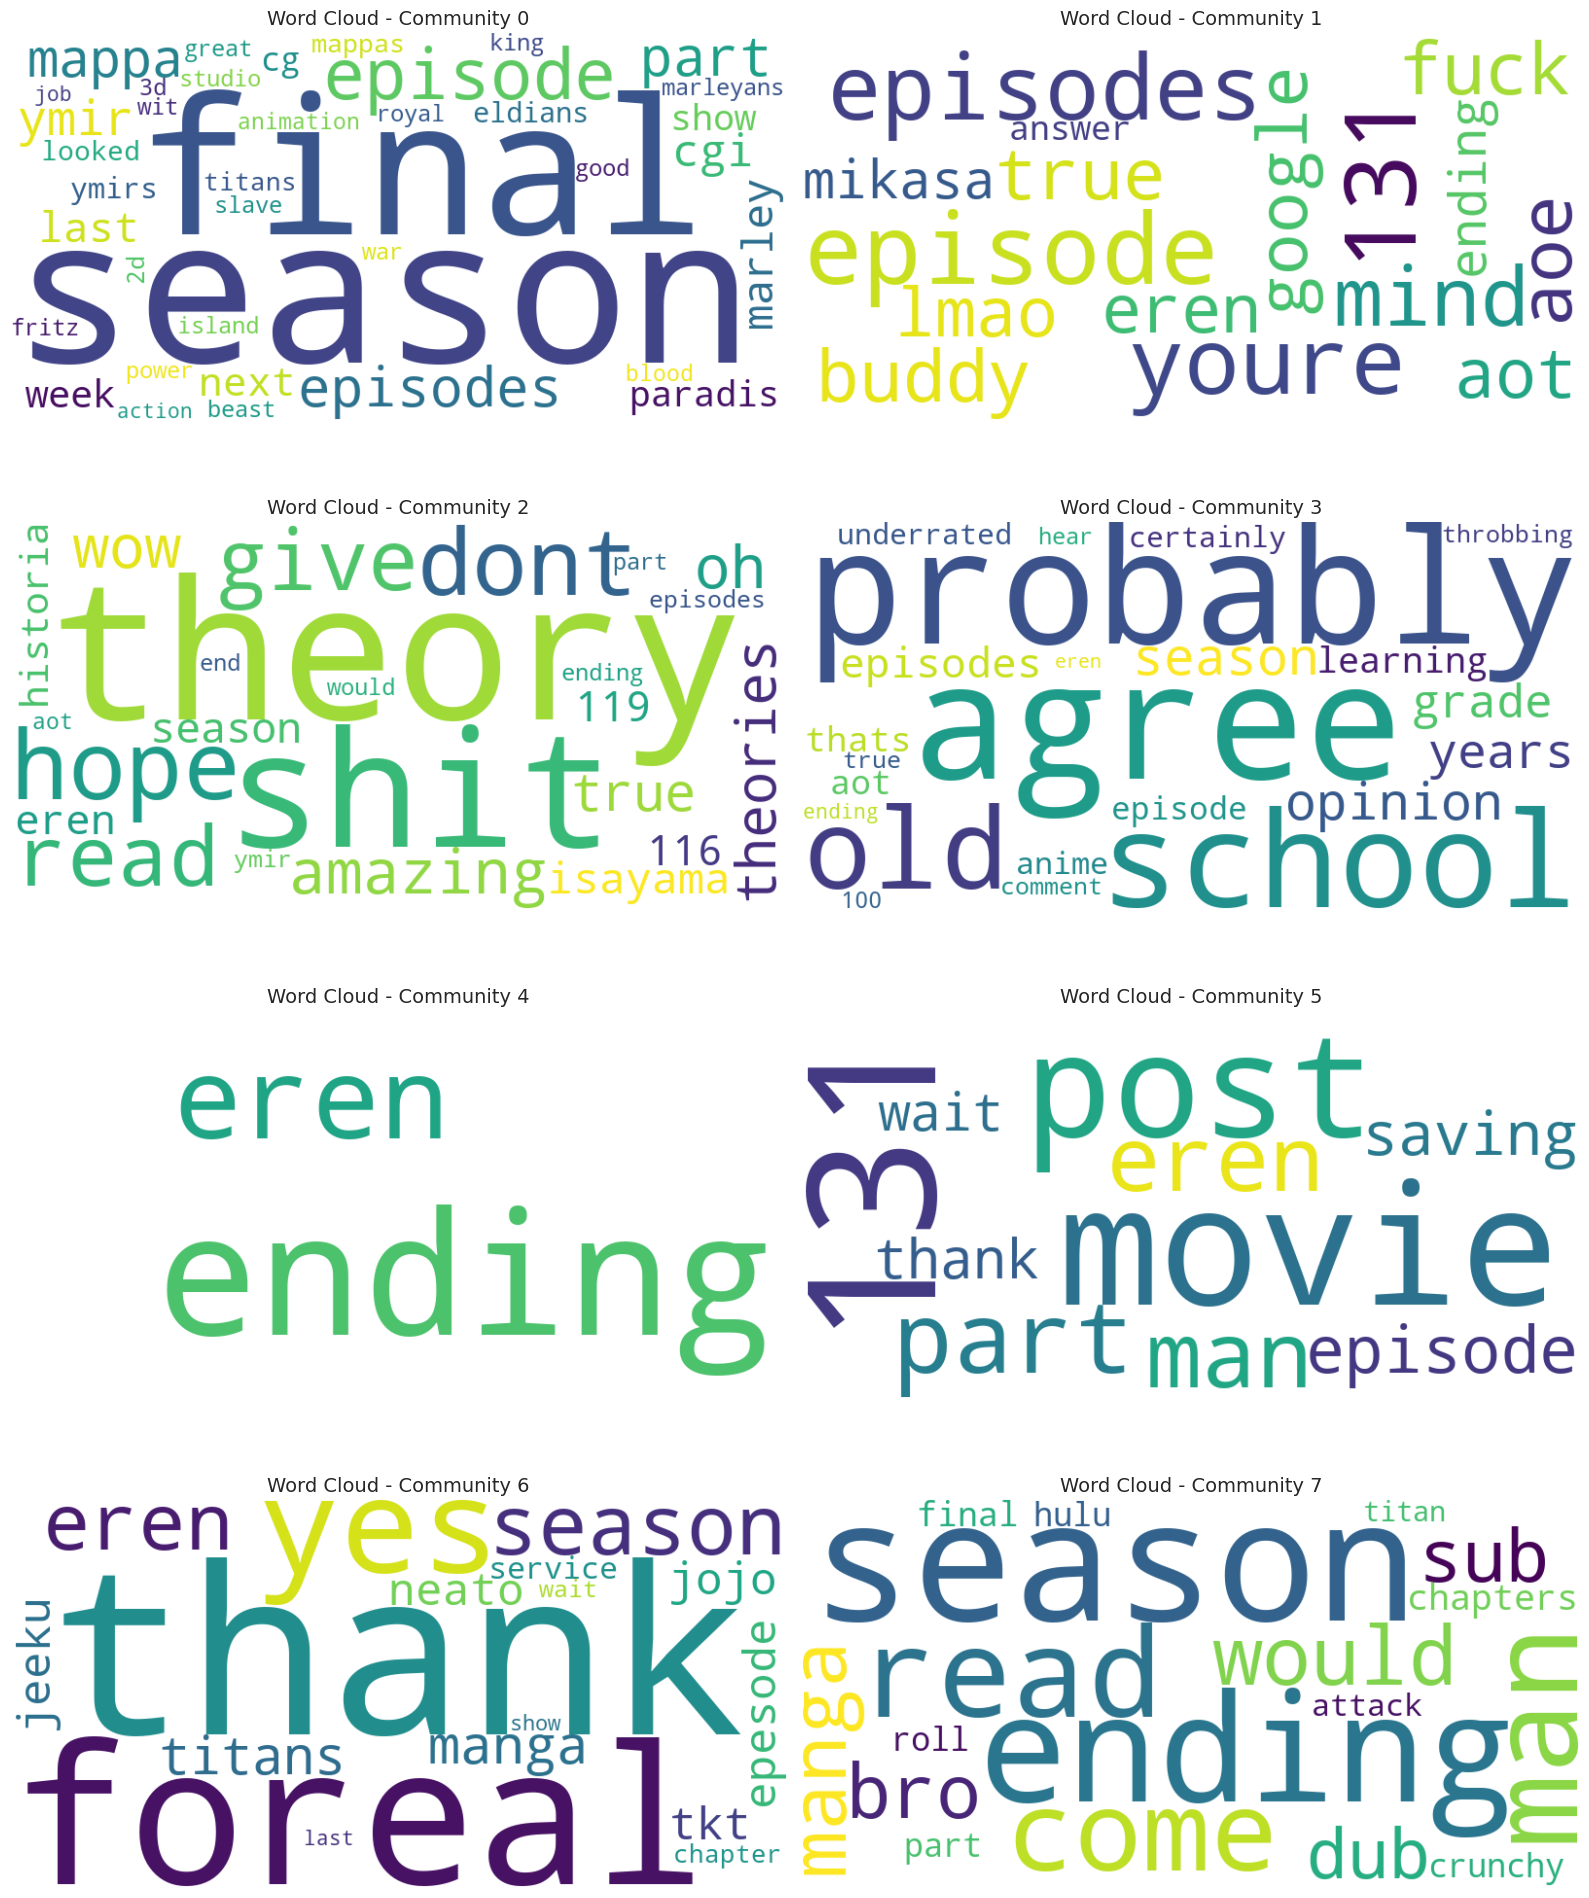

In [ ]:
rows = (len(top_communities) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(16, 5*rows))
axes = axes.flatten()

STOPWORDS = set(stopwords.words('english')).union({
    "like", "just", "really", "even", "one", "get", "thing", "things", "also"
})

# NUMBER OF TOPICS TO SHOW
top_n = 5

for i, comm in enumerate(top_communities):
    model = topic_models[comm]
    topic_info = model.get_topic_info()

    # Remove outlier topic -1
    topic_info = topic_info[topic_info["Topic"] != -1]
    if topic_info.empty:
        axes[i].text(0.5, 0.5, f"No topics for Community {comm}",
                     ha='center', va='center', fontsize=14)
        axes[i].axis('off')
        continue

    top_topics = topic_info.nlargest(top_n, 'Count')[["Topic", "Count"]]

    word_freq = {}
    for _, row in top_topics.iterrows():
        topic_id = row["Topic"]
        topic_count = row["Count"]
        for word, weight in model.get_topic(topic_id):
            word = word.lower()
            if word not in STOPWORDS:
                # Weight by topic size
                word_freq[word] = word_freq.get(word, 0) + (weight * topic_count)

    if not word_freq:
        axes[i].text(0.5, 0.5, f"No keywords left\nafter stopword removal",
                     ha='center', va='center', fontsize=12)
        axes[i].axis('off')
        continue

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Word Cloud - Community {comm}", fontsize=14)

# Hide any unused axes
for i in range(len(top_communities), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Topic modeling per time window

time periods:

1. start - mid_2020
2. mid_2020 - mid_2021
3. mid_2021 - mid_2022
4. mid_2022 - end

In [ ]:
mid_2020 = pd.Timestamp("2020-06-30")
mid_2021 = pd.Timestamp("2021-06-30")
mid_2022 = pd.Timestamp("2022-06-30")

df_comments["created_dt"] = pd.to_datetime(df_comments["created_utc"], unit="s")

def assign_period(dt):
    if dt <= mid_2020:
        return "period_1 (until mid_2020)"
    elif dt <= mid_2021:
        return "period_2 (mid_2020 → mid_2021)"
    elif dt <= mid_2022:
        return "period_3 (mid_2021 → mid_2022)"
    else:
        return "period_4 (mid_2022 → end)"

df_comments["custom_period"] = df_comments["created_dt"].apply(assign_period)


In [ ]:
period_topic_results = {}

for period, group in df_comments.groupby("custom_period"):
    texts = group["text_comment"].dropna().tolist()

    if len(texts) < 10:
        print(f"Skipping {period}, not enough data ({len(texts)} comments)")
        continue

    print(f"\nRunning BERTopic for: {period} ({len(texts)} comments)")

    topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=False)
    topics, probs = topic_model.fit_transform(texts)

    topic_info = topic_model.get_topic_info()
    topic_info["Representative_Docs"] = [
        topic_model.get_representative_docs(i) for i in topic_info.Topic
    ]

    period_topic_results[period] = {
        "model": topic_model,
        "info": topic_info,
        "texts": texts,
        "topics": topics,
    }



Running BERTopic for: period_1 (until mid_2020) (286 comments)

Running BERTopic for: period_2 (mid_2020 → mid_2021) (8696 comments)

Running BERTopic for: period_3 (mid_2021 → mid_2022) (3021 comments)

Running BERTopic for: period_4 (mid_2022 → end) (2001 comments)


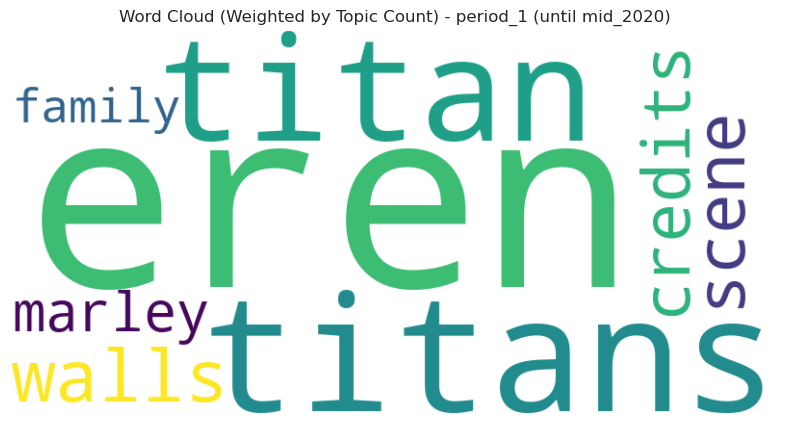

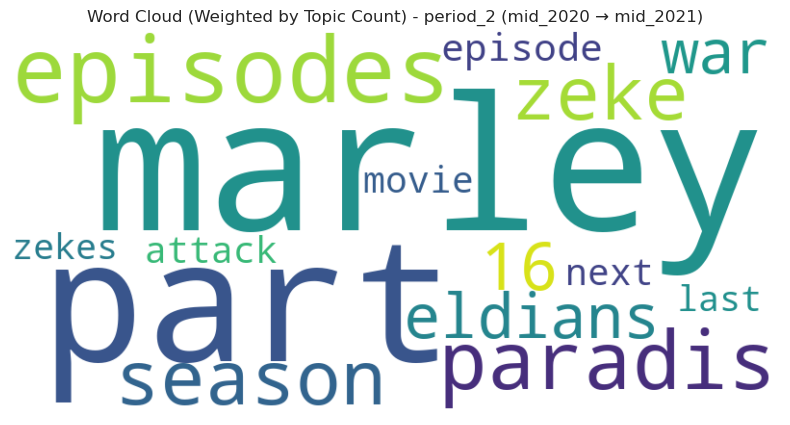

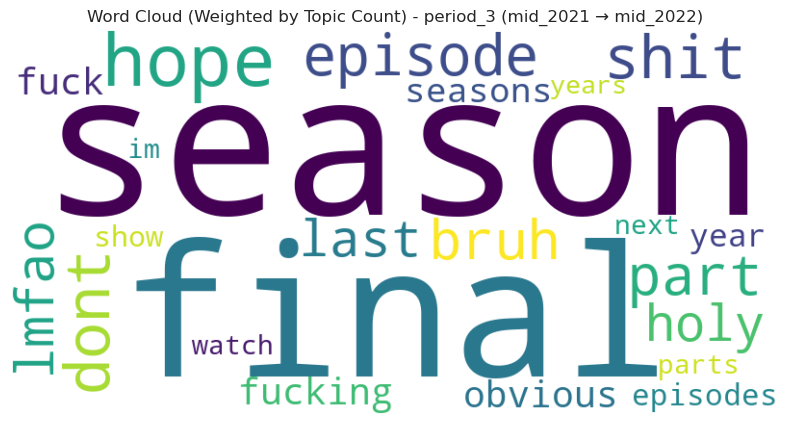

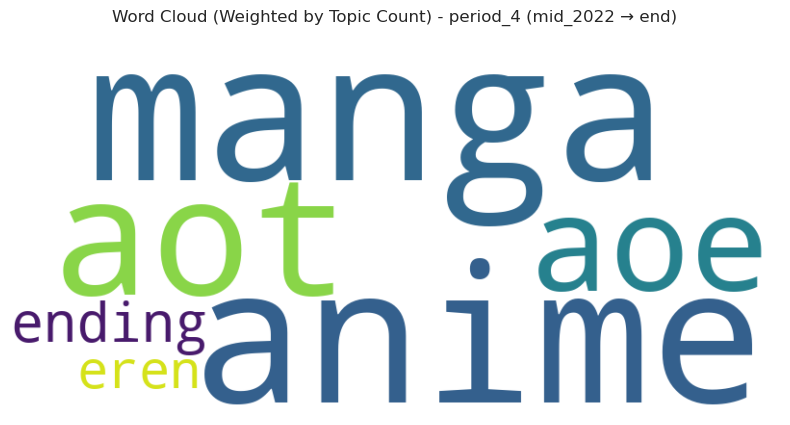

In [ ]:
STOPWORDS = set(stopwords.words('english')).union({
    "like", "just", "really", "even", "one", "get", "thing", "things", "also"
})
# NUMBER OF TOPICS TO SHOW
top_n = 3 

for period, data in period_topic_results.items():
    topic_model = data["model"]
    topic_info = topic_model.get_topic_info()

    # Remove outlier topic -1
    topic_info = topic_info[topic_info["Topic"] != -1]
    if topic_info.empty:
        print(f"No valid topics for {period}")
        continue

    top_topics = topic_info.nlargest(top_n, 'Count')[["Topic", "Count"]]

    # Aggregate keywords across top N topics, weighted by topic Count
    word_freq = {}
    for _, row in top_topics.iterrows():
        topic_id = row["Topic"]
        topic_count = row["Count"]
        for word, weight in topic_model.get_topic(topic_id):
            word = word.lower()
            if word not in STOPWORDS:
                # Multiply weight by topic size (Count)
                word_freq[word] = word_freq.get(word, 0) + (weight * topic_count)

    if not word_freq:
        print(f"No keywords left for {period} after stopword removal")
        continue

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud (Weighted by Topic Count) - {period}")
    plt.show()


As we expect from the story of the manga we have:
1. start - mid_2020: eren and titans
2. mid_2020 - mid_2021: war between marley and paradis
3. mid_2021 - mid_2022: finale... shit, hope, fuck, bruh, lmfao
4. mid_2022 - end: just the end